# 🎶 Predicting Lyrics
<hr>
<br>
<b> Group name: <strike>AA</strike> <i>My Machine Learning Romance</i> </b> <br>
- Fiorella Tenorio <br>
- Katja Wittfoth <br>
- Rebecca Reilly <br>
- Victoria Suarez <br>
- Viviana Márquez <br>

<br>
<img src='USF.png', style="width:200px;" align="left">
Friday, December 7th, 2018. <br>
<b> MSDS 621 </b> - Introduction to Machine Learning 

## Goal 
<center>
    <img src="are you smarter.png">
    <big>Predict genre based on lyrics</big><br><br>
    🥊 Supervised <i>vs.</i> Unspervised  <i>vs.</i> Humans 🥊
</center> 

## Workflow Pipeline
<center>
    <img src="workflow2.png" style="height:500px">
</center> 

In [1]:
# Libraries
import warnings
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction import stop_words
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator


import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score


import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline
import seaborn as sns
sns.set()

warnings.filterwarnings('ignore')

In [2]:
# Read data
df = pd.read_csv('/Users/vivianamarquez/Desktop/USF/3. Fall 18/Machine Learning/ML Project/lyrics.csv')

In [3]:
# Clean data
def clean_lyrics(text):
    text = re.sub('\n', ' ', text)  # removes new lines
    text = re.sub('\d', '', text)  # removes numbers
    text = re.sub('\t', '', text)  # removes tabs
    text = re.sub('[^A-Za-z ]', '', text)  # removes special character
    text = re.sub('\[Verse\s*\d*:]', ' ', text)  # remove verse indicators
    text = re.sub('\s+', ' ', text)
    words = text.split(" ")
    words = [w for w in words if len(w) > 2]  # removes a, an, to, at, be, ...
    return ' '.join(words)


df = df[pd.notnull(df['lyrics'])]
df = df[df['genre'] != 'Not Available']
df = df[df['genre'] != 'Other']
df['lyrics_clean'] = df.lyrics.apply(clean_lyrics)

df_clean = df[(df.genre == 'Country') | (df.genre == 'Metal') |
              (df.genre == 'Hip-Hop') | (df.genre == 'Jazz') | (df.genre == 'Electronic')]

df_clean = df_clean.sample(frac=1)  # shuffle

## 📊 1. Get data and pre-process

- 380,000+ lyrics  from MetroLyrics in <a href="https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics">Kaggle</a>

#### 🛁 Cleaning 
- Remove: `Null` lyrics, "Not available" genre, punctuation, numbers, symbols, spaces, stop words.
- Shuffle data.
- **Genres**: Country, Metal, Hip-Hop, Jazz, Electronic.

In [4]:
df_clean.head()

,index,song,year,artist,genre,lyrics,lyrics_clean
326553,326553,atlantic-coastal-line,2014,charley-pride,Country,Everybody calls me Bo\nI got no money but I ho...,Everybody calls got money but hold row Some fo...
256831,256831,you-know,2007,anja-garbarek,Electronic,Did i tell you\nWhere i went this morning ?\nD...,Did tell you Where went this morning Did tell ...
82525,82525,more-than-ever,2007,evergrey,Metal,Time for a breather let it all sink in\nA paus...,Time for breather let all sink pause from the ...
298073,298073,sliding,2009,brisco,Hip-Hop,Let's Do It\nMister Beat's( What It Is)\nBrisc...,Lets Mister Beats What Brisco Yea Come Verse S...
262662,262662,ansuz-astral,2006,enslaved,Metal,"Tekst: Ivar BjÃ¨rnson]\nANSUZ, ANSUZ!\n- Skipe...",Tekst Ivar Bjrnson ANSUZ ANSUZ Skipet kai Aldr...


## 👠 2. Modeling

### ✂️ Splitting data

In [5]:
train, test = train_test_split(df_clean, test_size=0.2)
train_lyrics = train['lyrics']
train_genre = train['genre']
test_lyrics = test['lyrics']
test_genre = test['genre']

### 🥊 Supervised models

- Pipelines: 
   - Vectorizers: CountVectorizer, TfidfVectorizer
   - Estimators: MultinomialNB, LogisticRegression, LinearSVC

- GridSearch

In [6]:
pipe_lr_cv = Pipeline([
    ('cv', CountVectorizer(stop_words='english',
                             lowercase=False,
                             analyzer='word')),
    ('lr', LogisticRegression())
])

pipe_lr_tf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english',
                             lowercase=False,
                             analyzer='word')),
    ('lr', LogisticRegression())
])

pipe_nb_cv = Pipeline([
    ('cv', CountVectorizer(stop_words='english',
                             lowercase=False,
                             analyzer='word')),
    ('nb', MultinomialNB())
])

pipe_nb_tf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english',
                             lowercase=False,
                             analyzer='word')),
    ('nb', MultinomialNB())
])

pipe_svc_cv = Pipeline([
    ('cv', CountVectorizer(stop_words='english',
                             lowercase=False,
                             analyzer='word')),
    ('svc', LinearSVC())
])

pipe_svc_tf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english',
                             lowercase=False,
                             analyzer='word')),
    ('svc', LinearSVC())
])

pipelines = [pipe_lr_cv, pipe_lr_tf, pipe_nb_cv, pipe_nb_tf, pipe_svc_cv, pipe_svc_tf]

In [7]:
# Fit pipe
for pipe in pipelines:
    pipe.fit(train_lyrics, train_genre)

In [8]:
methods = []

for pipe in pipelines:
    name = pipe.steps[-1][1].__class__.__name__.split('.')[-1]
    vect = pipe.steps[0][1].__class__.__name__.split('.')[-1]

    predicted = pipe.predict(test_lyrics)
    accuracy = accuracy_score(predicted, test['genre'])
    conf_mat = confusion_matrix(test['genre'], predicted)

    methods.append([name, vect, accuracy, conf_mat])

methods = pd.DataFrame(methods)
methods.columns = ['Model', 'Vectorizer', 'Accuracy', "Confussion_Matrix"]
methods["Strategy"] = methods["Model"] + " -- " + methods["Vectorizer"]
methods.set_index(["Strategy"], inplace=True)

In [9]:
methods

,Model,Vectorizer,Accuracy,Confussion_Matrix
Strategy,,,,
LogisticRegression -- CountVectorizer,LogisticRegression,CountVectorizer,0.773421,"[[2230, 98, 99, 275, 178], [206, 528, 207, 109..."
LogisticRegression -- TfidfVectorizer,LogisticRegression,TfidfVectorizer,0.767657,"[[2275, 66, 130, 187, 222], [217, 391, 296, 76..."
MultinomialNB -- CountVectorizer,MultinomialNB,CountVectorizer,0.728828,"[[2600, 22, 72, 50, 136], [511, 317, 279, 48, ..."
MultinomialNB -- TfidfVectorizer,MultinomialNB,TfidfVectorizer,0.627162,"[[1093, 9, 1315, 1, 462], [49, 53, 908, 6, 535..."
LinearSVC -- CountVectorizer,LinearSVC,CountVectorizer,0.731488,"[[2048, 156, 120, 385, 171], [174, 614, 210, 1..."
LinearSVC -- TfidfVectorizer,LinearSVC,TfidfVectorizer,0.782416,"[[2260, 102, 94, 264, 160], [184, 584, 240, 11..."


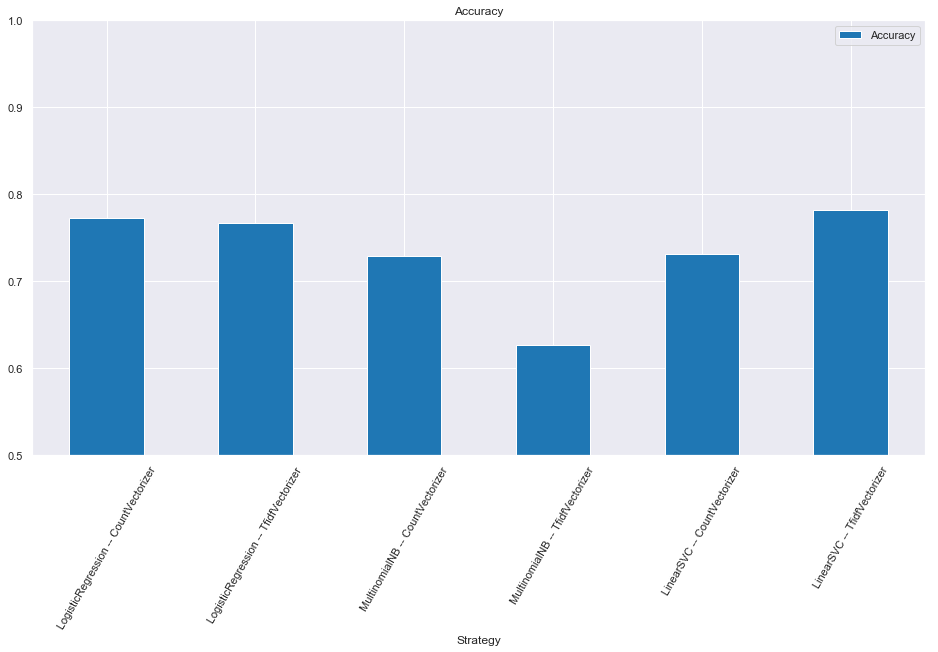

In [14]:
#%matplotlib inline
methods.plot(figsize=(16, 8),kind='bar',title='Accuracy', rot=60, ylim=(0.5,1),colormap='tab10')

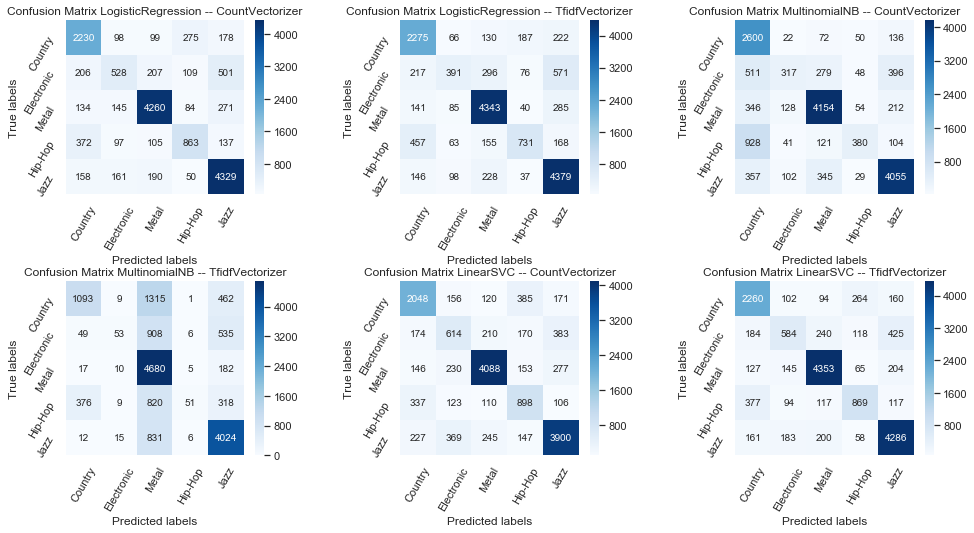

In [15]:
#%matplotlib inline
methods = methods.reset_index()
fig = plt.figure(figsize=(16, 8))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(1, 7):
    ax = fig.add_subplot(2, 3, i)
    sns.heatmap(methods["Confussion_Matrix"].values[i-1], annot=True, fmt = 'd', ax = ax, cmap="Blues");
    ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels'); 
    ax.set_title(f'Confusion Matrix {methods["Strategy"].values[i-1]}');
    ax.xaxis.set_ticklabels(df_clean.genre.unique(), rotation=60 ); 
    ax.yaxis.set_ticklabels(df_clean.genre.unique(), rotation=60 );

We know LinearSVC -- TfidfVectorizer is the best.
Go back and do manual grid search.

In [32]:
grid = {'svc__loss': ['hinge', 'squared_hinge']}

gs = GridSearchCV(pipe_svc_tf,
                  param_grid=grid,
                  scoring='accuracy')

In [33]:
gs.fit(train_lyrics, train_genre)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'svc__loss': ['hinge', 'squared_hinge']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [42]:
gs.cv_results_

{'mean_fit_time': array([20.50053144,  9.84403261]),
 'std_fit_time': array([0.88125275, 0.73771802]),
 'mean_score_time': array([3.20641327, 3.290814  ]),
 'std_score_time': array([0.03288963, 0.13173956]),
 'param_svc__loss': masked_array(data=['hinge', 'squared_hinge'],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'svc__loss': 'hinge'}, {'svc__loss': 'squared_hinge'}],
 'split0_test_score': array([0.76813453, 0.76813453]),
 'split1_test_score': array([0.7663436 , 0.76686621]),
 'split2_test_score': array([0.77265168, 0.7708462 ]),
 'mean_test_score': array([0.76904317, 0.76861559]),
 'std_test_score': array([0.00265415, 0.00166001]),
 'rank_test_score': array([1, 2], dtype=int32),
 'split0_train_score': array([0.88901295, 0.94272479]),
 'split1_train_score': array([0.8878094 , 0.94120861]),
 'split2_train_score': array([0.88783582, 0.94261146]),
 'mean_train_score': array([0.88821939, 0.94218162]),
 'std_train_score': array([0.0

In [34]:
gs.best_estimator_.steps[0][1]  # best model

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [43]:
pred = gs.predict(test_lyrics)

In [44]:
gs.score(pred)

ValueError: Expected array-like (array or non-string sequence), got None

# Recap ✍️